# Wake county restaurant inspection project by Paige McKenzie
Implements methods discussed in related [blog post]().

Data courtesy of Wake County Open Data (pulled 7/18/19):
* [Restaurants](https://data-wake.opendata.arcgis.com/datasets/restaurants-in-wake-county)
* [Inspections](https://data-wake.opendata.arcgis.com/datasets/food-inspections)
* [Violations](https://data-wake.opendata.arcgis.com/datasets/food-inspection-violations)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Import data to Pandas dataframes

In [2]:
rest = pd.read_csv('./data/Restaurants_in_Wake_County.csv', index_col=['OBJECTID'],
                  parse_dates=['RESTAURANTOPENDATE'], infer_datetime_format=True)

insp = pd.read_csv('./data/Food_Inspections.csv', index_col=['OBJECTID'],
                  parse_dates=['DATE_'], infer_datetime_format=True)

viol = pd.read_csv('./data/Food_Inspection_Violations.csv',
                  parse_dates=['INSPECTDATE'], infer_datetime_format=True, low_memory=False)

## General data exploration and cleaning
### Restaurants dataset

In [3]:
rest.head(2)

,HSISID,NAME,ADDRESS1,ADDRESS2,CITY,STATE,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,FACILITYTYPE,PERMITID,X,Y,GEOCODESTATUS
OBJECTID,,,,,,,,,,,,,,
2001,4092030273,RARE EARTH FARMS (WCID #512),407 GLENWOOD AVE,NaN,RALEIGH,NaN,27606,(919) 349-6080,2015-01-16 00:00:00+00:00,Mobile Food Units,18359,-78.647761,35.785405,M
2002,4092015000,GRACE Christian School Kitchen,801 Buck Jones RD,NaN,RALEIGH,NaN,27606,(919) 783-6618,2007-11-06 00:00:00+00:00,Restaurant,3377,-78.736937,35.771907,M


In [4]:
pd.concat([rest.dtypes.rename("Datatype"),
           rest.apply(pd.Series.nunique).rename("# of unique values"),
            rest.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

,Datatype,# of unique values,% of missing values
ADDRESS1,object,3150,0.000000
ADDRESS2,object,265,0.886840
CITY,object,14,0.189159
FACILITYTYPE,object,10,0.000000
GEOCODESTATUS,object,3,0.000000
HSISID,int64,3579,0.000000
NAME,object,3449,0.000000
PERMITID,int64,3579,0.000000
PHONENUMBER,object,3059,0.044426
POSTALCODE,object,539,0.000000


In [5]:
# city is not standardized - lowercase, replace hyphen with space
rest['CITY'] = rest['CITY'].str.lower().str.replace('-', ' ')

# combine any 'CITY' value with less than 10 data points into an "other" category, treat nulls the same
rest.loc[rest['CITY'].isin(rest['CITY'].value_counts()[rest['CITY'].value_counts()<10].index),
        'CITY'] = 'other'
rest['CITY'].fillna('other', inplace=True)

In [6]:
# postal code isn't standardized either - abbreviate to 5 digit format, treat as integer
rest['POSTALCODE'] = rest['POSTALCODE'].apply(lambda st:int(st[:5]))

In [7]:
from re import findall

# clean name by removing odd characters, lowercase (combining weird apostrophes)
rest['NAME'] = rest['NAME'].str.lower().str.replace('`', "'").apply(lambda x:' '.join(findall(r"([a-z'-]+)(?=\s|$)", x)))

In [8]:
# there is no reason to retain the STATE field - it has no information, and all of Wake County is in NC anyway
rest.drop('STATE', axis=1, inplace=True)

In [9]:
pd.concat([rest.dtypes.rename("Datatype"),
           rest.apply(pd.Series.nunique).rename("# of unique values"),
            rest.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

,Datatype,# of unique values,% of missing values
ADDRESS1,object,3150,0.000000
ADDRESS2,object,265,0.886840
CITY,object,13,0.000000
FACILITYTYPE,object,10,0.000000
GEOCODESTATUS,object,3,0.000000
HSISID,int64,3579,0.000000
NAME,object,2485,0.000000
PERMITID,int64,3579,0.000000
PHONENUMBER,object,3059,0.044426
POSTALCODE,int64,57,0.000000


### Inspections dataset

In [10]:
# rename date column to match other table
insp.rename(columns={'DATE_':'INSPECTDATE'}, inplace=True)
insp.head(2)

,HSISID,SCORE,INSPECTDATE,DESCRIPTION,TYPE,INSPECTOR,PERMITID
OBJECTID,,,,,,,
1001,4092015443,96.0,2015-03-24 00:00:00+00:00,NaN,Inspection,Caroline Suggs,4768
1002,4092015443,94.0,2015-09-25 00:00:00+00:00,Follow-Up: 10/05/2015,Inspection,Jennifer Edwards,4768


In [11]:
insp['HSISID'].isin(rest['HSISID']).mean()

0.9722470155082004

We need to be able to connect inspections to restaurants, so we'll only retain rows where this is possible, about 97% of this dataset.

In [12]:
insp = insp[insp['HSISID'].isin(rest['HSISID'])]

In [13]:
pd.concat([insp.dtypes.rename("Datatype"),
           insp.apply(pd.Series.nunique).rename("# of unique values"),
            insp.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

,Datatype,# of unique values,% of missing values
DESCRIPTION,object,10828,0.371948
HSISID,int64,3510,0.000000
INSPECTDATE,"datetime64[ns, UTC]",1880,0.000000
INSPECTOR,object,50,0.000000
PERMITID,int64,3510,0.000000
SCORE,float64,52,0.000000
TYPE,object,2,0.000000


### Violations dataset

In [14]:
viol.head(2)

,OBJECTID,HSISID,INSPECTDATE,CATEGORY,STATECODE,CRITICAL,QUESTIONNO,VIOLATIONCODE,SEVERITY,SHORTDESC,INSPECTEDBY,COMMENTS,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE,CDCRISKFACTOR,CDCDATAITEM,PERMITID
0,1001,NaN,2014-02-25 00:00:00+00:00,Approved Source,".2653,.2655",Yes,12,3-203.12,Priority Foundation,"Required records available: shellstock tags, p...",Melissa Harrison,3-203.12; Priority Foundation; Clams stored in...,2.0,Out,R,Unsafe Source,NaN,4067
1,1002,NaN,2014-05-22 00:00:00+00:00,Approved Source,".2653,.2655",Yes,12,3-203.12,Priority Foundation,"Required records available: shellstock tags, p...",Jennifer Edwards,3-203.12; Priority Foundation; Shellstock tags...,0.0,Out,VR,Unsafe Source,NaN,7605


In [15]:
pd.concat([viol.dtypes.rename("Datatype"),
           viol.apply(pd.Series.nunique).rename("# of unique values"),
            viol.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

,Datatype,# of unique values,% of missing values
CATEGORY,object,25,0.000000
CDCDATAITEM,object,5,0.926013
CDCRISKFACTOR,object,5,0.833124
COMMENTS,object,288664,0.001692
CRITICAL,object,2,0.045759
HSISID,float64,0,1.000000
INSPECTDATE,"datetime64[ns, UTC]",1893,0.000000
INSPECTEDBY,object,54,0.000245
OBJECTID,int64,317906,0.000000
OBSERVATIONTYPE,object,5,0.000937


The data came without HSISID populated, but we may be able to crosswalk with the other tables to get this information. However, it is worth noting that the `violations` table has dramatically more unique `PERMITID` values than the other tables, meaning it will be impossible to connect these violations to permits/restaurants in the dataset.

In [16]:
viol['PERMITID'].isin(insp['PERMITID']).mean()

0.17445722949551126

In fact, it looks like about 17% of the rows in the `violations` table can be connected to the others, so this is the subset we'll keep.

In [17]:
# check there is one HSISID for each PERMITID
assert (rest.groupby('PERMITID')['HSISID'].nunique()>1).sum()==0

viol = viol.drop('HSISID', axis=1).join(insp.set_index('PERMITID')['HSISID'].drop_duplicates(),
         on='PERMITID', how='inner')

In [18]:
pd.concat([viol.dtypes.rename("Datatype"),
           viol.apply(pd.Series.nunique).rename("# of unique values"),
            viol.apply(pd.Series.isnull).mean().rename("% of missing values")],
          axis=1, sort=True)

,Datatype,# of unique values,% of missing values
CATEGORY,object,25,0.000000
CDCDATAITEM,object,5,0.926182
CDCRISKFACTOR,object,5,0.831792
COMMENTS,object,51395,0.001388
CRITICAL,object,2,0.048394
HSISID,int64,941,0.000000
INSPECTDATE,"datetime64[ns, UTC]",1697,0.000000
INSPECTEDBY,object,51,0.000144
OBJECTID,int64,55461,0.000000
OBSERVATIONTYPE,object,5,0.000974


We've lost data, but at least everything that remains is usable.

### Visualizations

In [19]:
print(rest.index.nunique(), "restaurants")
print(len(viol), "violations")
print(len(insp[['HSISID', 'INSPECTDATE']].drop_duplicates()), "inspectors")
print(insp['INSPECTOR'].nunique(), "inspectors")

3579 restaurants
55461 violations
34848 inspectors
50 inspectors


In [20]:
print("Date range:\n{}".format(insp['INSPECTDATE'].agg([min, max])))

Date range:
min   2012-09-21 00:00:00+00:00
max   2019-06-26 00:00:00+00:00
Name: INSPECTDATE, dtype: datetime64[ns, UTC]


C:\Users\MPAIGE\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


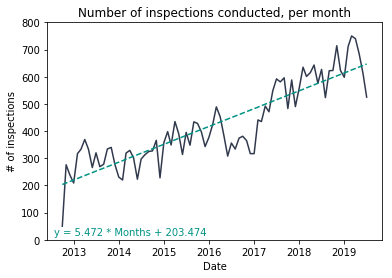

In [21]:
data = insp.groupby(pd.Grouper(freq="M", key='INSPECTDATE')).size()
plt.plot(data, color='#31394d')
plt.ylim((0,800))
plt.title("Number of inspections conducted, per month")
plt.ylabel("# of inspections")
plt.xlabel("Date")

# calc the trendline
z = np.polyfit(list(range(len(data))), data.values, 1)
p = np.poly1d(z)
plt.plot(data.index, p(list(range(len(data)))), color='#009384', linestyle='--')
# the line equation:
plt.figtext(x=.14, y=.14, s="y = %.3f * Months + %.3f"%(z[0],z[1]), color='#009384')

plt.show()

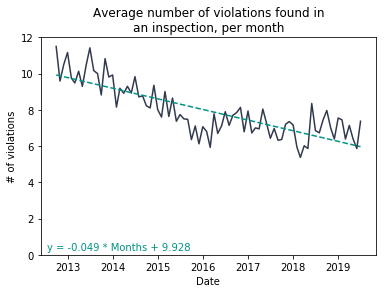

In [22]:
data = viol.groupby([pd.Grouper(freq="M", key='INSPECTDATE'), viol['PERMITID']]).size().rename("VIOLCOUNT").groupby(level=0).mean()
plt.plot(data, color='#31394d')
plt.ylim((0,12))
plt.title("Average number of violations found in\nan inspection, per month")
plt.ylabel("# of violations")
plt.xlabel("Date")

# calc the trendline
z = np.polyfit(list(range(len(data))), data.values, 1)
p = np.poly1d(z)
plt.plot(data.index, p(list(range(len(data)))), color='#009384', linestyle='--')
# the line equation:
plt.figtext(x=.14, y=.14, s="y = %.3f * Months + %.3f"%(z[0],z[1]), color='#009384')

plt.show()

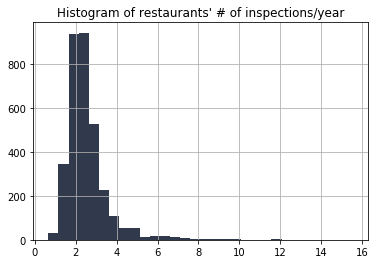

In [23]:
insp.groupby('HSISID').size().div(insp.groupby('HSISID')['INSPECTDATE'].apply(lambda s:(s.max()-s.min()).days/365
                                                                             if len(s)>1 else None)).dropna().hist(bins=30, color='#31394d')
plt.title("Histogram of restaurants' # of inspections/year")
plt.show()

## Goal
Imagine it's Christmas break, end of 2018, and we've scheduled restaurant inspections for the first 6 months of 2019. In hopes of increasing the scores of at-risk restaurants, we'd like to implement a mailing campaign, targeted at restaurants who we expect to score low, giving them information about common violations and advice for proper procedures. Hopefully, this will elicit improvements before our inspector visits, and they will receive a higher inspection `SCORE`. 

Due to budget constraints, we can only mail to 500 restaurants in this campaign. We want to target the most "at-risk" customers using data science. For this, we want a model that can accurately predict which inspection is likely to receive a low `SCORE`, so we can target them.

We define a "low" `SCORE` as `SCORE`<93.

In [24]:
validation_date = '2019-01-01'
test_date = '2018-07-01'

**Approach:**

We will first engineer a set of features from what we know about each restaurant. This set will be split into a train and test set using a 70/30 split. Using appropriate models and grid search to select optimum parameters, we'll identify the best model using cross validation within the training set, and then the model that performs best on the reserved testing set will be selected for production.

**Feature engineering:**

Features will include:
* the number of days the restaurant has been open (`TIMEOPEN`, integer)
* the number of days since the restaurant was last inspected (`TIMESINCE`, integer)
* the number of other restaurants (unique HSISIDs) with the same name (`CHAINCOUNT`, integer)
* the number of inspections for the restaurant (`INSPCOUNT`, integer)
* whether the restaurant has ever needed a re-inspection (`WASREINSP`, binary)
* the average number of violations per inspection for that restaurant (`AVGVIOL`, float)

Just for fun and in case of some seasonality to inspections, we'll throw in cyclical features for month:
* `SINMONTH` (float)
* `COSMONTH` (float)

Including preexisting features:
* `FACILITYTYPE` (categorical and will be converted to dummy variables)
* `CITY` (categorical and will be converted to dummy variables)
* `POSTALCODE` (integer, due to the fact that zipcodes that are close in number tend to be geographically similar as well)
* `AREACODE` (categorical, will be extracted from the existing `PHONE NUMBER` field

Wrapping in a few details on the restaurant's most recent inspection, prior to that in question:
* the type of the restaurant's most recent inspection (`TYPE_previous`, categorical to dummy)
* the inspector who completed the most recent inspection (`INSPECTOR_previous`, categorical to dummy)
* the previous inspection score (`SCORE_previous`, float)

In [25]:
def engineer_features(insp, rest):
    features = insp[['HSISID', 'INSPECTDATE', 'SCORE', 'INSPECTOR', 'TYPE']].join(
        rest.set_index('HSISID')[['NAME', 'CITY', 'RESTAURANTOPENDATE', 'FACILITYTYPE', 'PHONENUMBER']], on='HSISID', how='left')

    # calculate number of unique HSISID's with the same name (# of chain locations, maybe)
    features = features.join((features.groupby('NAME')['HSISID'].nunique()).rename('CHAINCOUNT'), on='NAME')

    # calculate number of inspections
    features = features.join(insp.groupby('HSISID').size().rename("INSPCOUNT").reindex(features['HSISID'].unique(), fill_value=0), on='HSISID')

    # whether the restaurant ever needed a re-inspection
    features['WASREINSP'] = features['HSISID'].isin(insp.loc[insp['TYPE']=='Re-Inspection', 'HSISID'].unique()).astype(int)

    # average number of violations per inspection
    features = features.join(insp.groupby(['HSISID', 'INSPECTDATE']).size().reindex(features[['HSISID', 'INSPECTDATE']], fill_value=0).mean(level=0).rename("AVGVIOL"),
                            on='HSISID')

    # self-merge to get information about previous inspection
    features = features.groupby('HSISID')[['SCORE', 'INSPECTOR', 'TYPE', 'INSPECTDATE']].apply(lambda group:
                 pd.concat([group.add_suffix('_previous'),
                            group.shift(-1).add_suffix('_current')],
                           axis=1, sort=True)).drop(['INSPECTOR_current', 'TYPE_current'], axis=1).\
    rename(columns={'INSPECTDATE_current':'INSPECTDATE'}).\
    merge(features, on=['HSISID', 'INSPECTDATE'], how='right').drop_duplicates()


    # time features
    features['TIMEOPEN'] = (features['INSPECTDATE'] - features['RESTAURANTOPENDATE']).dt.days
    features.loc[features['INSPECTDATE_previous'].isnull(), 'INSPECTDATE_previous'] = features['RESTAURANTOPENDATE']
    features['TIMESINCE'] = (features['INSPECTDATE'] - features['INSPECTDATE_previous']).dt.days
    from numpy import sin, cos
    from math import pi
    features['SINMONTH'] = features['INSPECTDATE'].dt.month.apply(lambda x:sin(2*pi*x/12))
    features['COSMONTH'] = features['INSPECTDATE'].dt.month.apply(lambda x:cos(2*pi*x/12))

    # derive area code feature as dummy columns
    features = pd.concat([features, 
                          pd.get_dummies(features['PHONENUMBER'].str[1:4])],
                         axis=1)

    # drop extra columns
    features = features.drop(['INSPECTOR', 'TYPE', 'RESTAURANTOPENDATE', 'INSPECTDATE_previous', 'SCORE_current', 'PHONENUMBER'], 
                             axis=1)
    
    # inpute missing values
    features.loc[features['INSPECTOR_previous'].isnull(), 'INSPECTOR_previous'] = 'none' # simply add a new category
    features.loc[features['TYPE_previous'].isnull(), 'TYPE_previous'] = 'none' # simply add a new category
    features['NAME'].fillna('', inplace=True)
    features['CHAINCOUNT'].fillna(1, inplace=True)
    # fill previous score with moving average
    features.loc[features['SCORE_previous'].isnull(), 'SCORE_previous'] = pd.merge_asof(features.sort_values('INSPECTDATE'), features.groupby(pd.Grouper(freq="M", key='INSPECTDATE'))['SCORE'].mean().shift().to_frame().add_suffix('_fill'),
              left_on='INSPECTDATE', right_index=True, direction='backward')['SCORE_fill']
    return features

### Time-travel
We will engineer features for training the models (all time, prior to `test_date`), testing the models (`test_date` to `validation_date`), and then see how our model would've done using the inspections after `validation_date`.

In [26]:
X = engineer_features(insp[insp['INSPECTDATE']<test_date], rest)

validation = engineer_features(insp, rest)
validation = validation[validation['INSPECTDATE']>=validation_date]

test = engineer_features(insp[insp['INSPECTDATE']<validation_date], rest)
test = test[test['INSPECTDATE']>=test_date]

For no reason at all, we will use NLP to parse the text in the restaurant's `NAME`, in hopes of extracting some insight into the cuisine type or food style (ie. `buffet` might indicate a higher chance of failing inspection). I've arbitrarily decided to choose the top 40 words from restaurant `NAME`, using most frequent words. Note that this will be "trained" using the training time period (`X`), and then applied to the prediction sets (`test`, `validation`).

While we're at it, we should also parse the categorical fields (`FACILITYTYPE`, `INSPECTOR_previous`, `TYPE_previous`, `CITY`), again using only the options present in training for the other sets.

In [27]:
# column size explodes from here as we add columns for words in the restaurant name, dummy columns
from sklearn.feature_extraction.text import CountVectorizer

# fit on training set
vectorizer = CountVectorizer(stop_words='english', binary=True, max_features=40)
vectorizer.fit(X['NAME'])

# apply to all sets
X = pd.concat([X.drop('NAME', axis=1), 
       pd.DataFrame(vectorizer.transform(X['NAME']).todense().astype(int),
         columns=vectorizer.vocabulary_, index=X.index)],
      axis=1)
# get dummy columns
X = pd.get_dummies(X, drop_first=False)

validation = pd.concat([validation.drop('NAME', axis=1), 
       pd.DataFrame(vectorizer.transform(validation['NAME']).todense().astype(int),
         columns=vectorizer.vocabulary_, index=validation.index)],
      axis=1)
validation = pd.get_dummies(validation, drop_first=False).reindex(X.columns, axis=1, fill_value=0)

test = pd.concat([test.drop('NAME', axis=1), 
       pd.DataFrame(vectorizer.transform(test['NAME']).todense().astype(int),
         columns=vectorizer.vocabulary_, index=test.index)],
      axis=1)
test = pd.get_dummies(test, drop_first=False).reindex(X.columns, axis=1, fill_value=0)

**Modeling:**

We'll use cross-validation on the `X` dataset with known scores, to determine optimal model parameters. The reserved `test` set will be used to choose the best model, hopefully controlling for over-fitting. Finally, we will re-fit the model using the process we identify as best, and see how we would perform on the `validation` set, had we actually implemented the model-building process to identify the 500 most "at-risk" restaurants.

In [28]:
(X['SCORE']<93).value_counts()

False    24703
True      2427
Name: SCORE, dtype: int64

Let's balance our classes, which should hopefully help the model separate the classes better. 

In [29]:
oversample = 2 # the number of times to include each positive target row
ratio = .3 # the goal target distribution (# of positive class)

In [30]:
X_neg = X[X['SCORE']<93]
X_pos = X[X['SCORE']>=93]

del X

In [31]:
X = X_pos.sample(int(oversample*len(X_pos)), replace=True).append(
    X_neg.sample(int((1/ratio-1)*oversample*len(X_pos)), replace=True))
del X_neg, X_pos

In [32]:
(X['SCORE']<93).value_counts()

True     115280
False     49406
Name: SCORE, dtype: int64

We've successfully balanced the data to 50:50.

Next, using all inspections prior to the `test_date` and after 2014, we'll implement cross-validation to choose optimal model parameters for a simple decision tree, bagging, boosting, and random forest classifiers.

In [33]:
# ignore inspections with missing vital data
X = X[X['SCORE'].notna()&(X['INSPECTDATE'].dt.year>=2014)]

y = (X['SCORE']<93).astype(int)
X = X.drop(['SCORE', 'INSPECTDATE'], axis=1)

# also separate test, validation into X, and y
y_test = (test['SCORE']<93).astype(int)
X_test = test.drop(['SCORE', 'INSPECTDATE'], axis=1)

y_val = (validation['SCORE']<93).astype(int)
X_val = validation.drop(['SCORE', 'INSPECTDATE'], axis=1)

del test, validation

### Begin modeling

In [34]:
# evaluate a random prediction
from sklearn.metrics import roc_auc_score

print("Train AUC:", roc_auc_score(y, np.random.choice([0,1], size=len(y), random_state=1)))
print("Mailing accuracy:", y_test.loc[np.random.choice(y_test.index, size=500)].mean())

Train AUC: 0.5001156884875647
Mailing accuracy: 0.106


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree_grid = GridSearchCV(tree, param_grid={'max_depth':[3,5,7,12],
                                     'max_features':[.5,.8,1.]},
                   scoring='roc_auc', cv=3, n_jobs=-1, 
                         verbose=1, return_train_score=True)
tree_grid.fit(X, y)

tree = tree_grid.best_estimator_

print("Train AUC:", roc_auc_score(y, tree.predict(X)))
print("Test AUC:", roc_auc_score(y_test, tree.predict(X_test)))

tree_mailing_acc = y_test.loc[pd.Series(tree.predict_proba(X_test)[:,1], index=X_test.index).nlargest(500).index].mean()
print("Mailing accuracy:", tree_mailing_acc)
print("Mailing lift:", round(tree_mailing_acc/y_test.mean(), 2))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   21.3s finished


Train AUC: 0.826862722931724
Test AUC: 0.7316181708586772
Mailing accuracy: 0.378
Mailing lift: 3.64


In [36]:
from sklearn.ensemble import BaggingClassifier

bags = BaggingClassifier(random_state=1, base_estimator=DecisionTreeClassifier(max_depth=6))
bags_grid = GridSearchCV(bags, param_grid={'n_estimators':[20,120,220],
                                     'max_samples':[.1,.3,.5]},
                   scoring='roc_auc', cv=3, n_jobs=-1, 
                         verbose=1, return_train_score=True)
bags_grid.fit(X, y)

bags = bags_grid.best_estimator_

print("Train AUC:", roc_auc_score(y, bags.predict(X)))
print("Test AUC:", roc_auc_score(y_test, bags.predict(X_test)))

bags_mailing_acc = y_test.loc[pd.Series(bags.predict_proba(X_test)[:,1], index=X_test.index).nlargest(500).index].mean()
print("Mailing accuracy:", bags_mailing_acc)
print("Mailing lift:", round(bags_mailing_acc/y_test.mean(), 2))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  6.7min finished


Train AUC: 0.7722373430499202
Test AUC: 0.7689709025152064
Mailing accuracy: 0.42
Mailing lift: 4.04


In [37]:
from sklearn.ensemble import GradientBoostingClassifier

boost = GradientBoostingClassifier(random_state=1, init=DecisionTreeClassifier(max_depth=6))
boost_grid = GridSearchCV(bags, param_grid={'n_estimators':[20,120,220],
                                            'max_features':[.3,.5,.8]},
                   scoring='roc_auc', cv=3, n_jobs=-1, 
                         verbose=1, return_train_score=True)
boost_grid.fit(X, y)

boost = boost_grid.best_estimator_

print("Train AUC:", roc_auc_score(y, boost.predict(X)))
print("Test AUC:", roc_auc_score(y_test, boost.predict(X_test)))

boost_mailing_acc = y_test.loc[pd.Series(boost.predict_proba(X_test)[:,1], index=X_test.index).nlargest(500).index].mean()
print("Mailing accuracy:", boost_mailing_acc)
print("Mailing lift:", round(boost_mailing_acc/y_test.mean(), 2))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.0min finished


Train AUC: 0.6912045881627807
Test AUC: 0.6850238369225711
Mailing accuracy: 0.422
Mailing lift: 4.06


In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, max_depth=6)
rf_grid = GridSearchCV(bags, param_grid={'n_estimators':[20,120],
                                     'max_samples':[.3,.5,.7],
                                     'max_features':[.3,.4,.5]},
                   scoring='roc_auc', cv=3, n_jobs=-1, 
                         verbose=1, return_train_score=True)
rf_grid.fit(X, y)

rf = rf_grid.best_estimator_

print("Train AUC:", roc_auc_score(y, rf.predict(X)))
print("Test AUC:", roc_auc_score(y_test, rf.predict(X_test)))

rf_mailing_acc = y_test.loc[pd.Series(rf.predict_proba(X_test)[:,1], index=X_test.index).nlargest(500).index].mean()
print("Mailing accuracy:", rf_mailing_acc)
print("Mailing lift:", round(rf_mailing_acc/y_test.mean(), 2))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.6min finished


Train AUC: 0.6973525205363926
Test AUC: 0.6909584086799276
Mailing accuracy: 0.424
Mailing lift: 4.08


**Conclusions:**

* The Decision Tree model has a rather large dropoff between train and test AUC, and performs poorly on the mailer simulation.
* The Bagging, Boosting and Random Forest models are very comparable in mailer simulation accuracy
* The Bagging model has dramatically higher train and test AUC than the Boosting and Random Forest models, with minimal dropoff between train and test

For these reasons, the Bagging model will be used for our actual mailer.

In [53]:
bags_grid.best_params_

{'max_samples': 0.1, 'n_estimators': 220}

In [51]:
y_val.mean()

0.0989065606361829

If we randomly mailed to restaurants about to be inspected, only 10% of the people we mailed to would be designated "at-risk".

In [52]:
y_val.loc[pd.Series(bags.predict_proba(X_val)[:,1], index=X_val.index).nlargest(500).index].mean()

0.416

Conversely, if we mailed to our 500 restaurants most likely to be "at-risk" according to the Bagging model, about 40% of the mailers would be received by "at-risk" restaurants, for about a 4x performance improvement.

In [50]:
for model in [tree, bags, boost, rf, boost_refit]:
    print(y_val.loc[pd.Series(model.predict_proba(X_val)[:,1], index=X_val.index).nlargest(500).index].mean())

0.384
0.416
0.404
0.402
0.402
